# **Exoplanet Detection Methods and Sensitivities**

EARTHSC 5205: Planetary Science

Professor Ji Wang

Rachel Price, Ethan Johnson, Malachi Roark

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.ascii

import astropy.constants as ac
import astropy.units as u

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import data
tab = astropy.io.ascii.read("/content/drive/My Drive/PS_2025.01.21_11.45.54.csv")

In [4]:
# Print column names
tab.colnames

['pl_name',
 'hostname',
 'default_flag',
 'sy_snum',
 'sy_pnum',
 'discoverymethod',
 'disc_year',
 'disc_facility',
 'soltype',
 'pl_controv_flag',
 'pl_refname',
 'pl_orbper',
 'pl_orbpererr1',
 'pl_orbpererr2',
 'pl_orbperlim',
 'pl_orbsmax',
 'pl_orbsmaxerr1',
 'pl_orbsmaxerr2',
 'pl_orbsmaxlim',
 'pl_rade',
 'pl_radeerr1',
 'pl_radeerr2',
 'pl_radelim',
 'pl_radj',
 'pl_radjerr1',
 'pl_radjerr2',
 'pl_radjlim',
 'pl_bmasse',
 'pl_bmasseerr1',
 'pl_bmasseerr2',
 'pl_bmasselim',
 'pl_bmassj',
 'pl_bmassjerr1',
 'pl_bmassjerr2',
 'pl_bmassjlim',
 'pl_bmassprov',
 'pl_orbeccen',
 'pl_orbeccenerr1',
 'pl_orbeccenerr2',
 'pl_orbeccenlim',
 'pl_insol',
 'pl_insolerr1',
 'pl_insolerr2',
 'pl_insollim',
 'pl_eqt',
 'pl_eqterr1',
 'pl_eqterr2',
 'pl_eqtlim',
 'ttv_flag',
 'st_refname',
 'st_spectype',
 'st_teff',
 'st_tefferr1',
 'st_tefferr2',
 'st_tefflim',
 'st_rad',
 'st_raderr1',
 'st_raderr2',
 'st_radlim',
 'st_mass',
 'st_masserr1',
 'st_masserr2',
 'st_masslim',
 'st_met',
 'st_me

In [5]:
# Print unique detection methods
np.unique(tab["discoverymethod"])

<Column name='discoverymethod' dtype='str29' length=11>
                   Astrometry
              Disk Kinematics
    Eclipse Timing Variations
                      Imaging
                 Microlensing
Orbital Brightness Modulation
                Pulsar Timing
  Pulsation Timing Variations
              Radial Velocity
                      Transit
    Transit Timing Variations

In [6]:
## Creating our solar system planet dataframe to overplot over plots

# Define planetary data
# Units: radius (km), mass (kg), period (days), semi-major axis (au)
planets = {
    "Mercury": {"radius": 2439.7, "mass": 0.33011e24, "period": 87.969, "semi_major_axis": 0.387},
    "Venus": {"radius": 6051.8, "mass": 4.8675e24, "period": 224.701, "semi_major_axis": 0.723},
    "Earth": {"radius": 6371, "mass": 5.97237e24, "period": 365.25, "semi_major_axis": 1.000},
    "Mars": {"radius": 3389.5, "mass": 0.64171e24, "period": 686.971, "semi_major_axis": 1.524},
    "Jupiter": {"radius": 71492, "mass": 1898.19e24, "period": 4332.59, "semi_major_axis": 5.204},
    "Saturn": {"radius": 58232, "mass": 568.34e24, "period": 10759.22, "semi_major_axis": 9.582},
    "Uranus": {"radius": 25362, "mass": 86.813e24, "period": 30687.15, "semi_major_axis": 19.218},
    "Neptune": {"radius": 24622, "mass": 102.413e24, "period": 60190.03, "semi_major_axis": 30.07}
}

# Prepare data for the DataFrame
data = []
for planet, info in planets.items():
    data.append({
        "Planet": planet,
        "Radius (R_earth)": info["radius"] / 6371,
        "Mass (M_earth)": info["mass"]  / 5.97237e24,
        "Orbital Period (days)": info["period"],
        "Semi-major Axis (au)": info["semi_major_axis"],
    })

# Create the DataFrame
solar_sys = pd.DataFrame(data)
print(solar_sys)

    Planet  Radius (R_earth)  Mass (M_earth)  Orbital Period (days)  \
0  Mercury          0.382938        0.055273                 87.969   
1    Venus          0.949898        0.815003                224.701   
2    Earth          1.000000        1.000000                365.250   
3     Mars          0.532020        0.107446                686.971   
4  Jupiter         11.221472      317.828601               4332.590   
5   Saturn          9.140166       95.161552              10759.220   
6   Uranus          3.980851       14.535771              30687.150   
7  Neptune          3.864699       17.147799              60190.030   

   Semi-major Axis (au)  
0                 0.387  
1                 0.723  
2                 1.000  
3                 1.524  
4                 5.204  
5                 9.582  
6                19.218  
7                30.070  


In [7]:
# Initialize colors for detection methods
colors = {
    "Radial Velocity": "red",
    "Transit": "blue",
    "Imaging": "green",
}

# Only use these selected detection methods
selected_methods = ["Radial Velocity", "Transit", "Imaging"]

In [24]:
# Converting between period and semi-major axis
  # a = ((G*M/4π^2) * P^2)^(1/3)
  # P = ((4π^2/G*M) * a^3)^(1/2)
# Converting between mass and radius
  # radius = ((3/(4π))*(mass/density))^(1/3)
  # mass = (4π/3)*(density*(radius)^3)

# Set constants
G = ac.G
m_solar = 0.5*u.solMass

# Set ranges for period and semi-major axes
values = np.linspace(-10, 10, 10000)
a = 10**values * u.AU # Range of semi-major axis values
period = 10**values * u.day # Range of period values

# Create formulas to convert between period and semi-major axis
def sma_to_period(a):
  return np.sqrt((4*np.pi**2 / (G * m_solar)) * a**3)
#
def period_to_sma(P):
  return ((G*m_solar/4*np.pi**2) * P**2)**(1/3)

# Create adjusted period and semi-major axis values
a_new = period_to_sma(period)
period_new = sma_to_period(a)


# Create a function that converts mass to radius
def planet_mass_to_radius(mass):
    """
    Convert planet mass to radius using the power-law relations.
    Parameters:
        mass (float or array-like): Mass of the planet in Earth masses.
    Returns:
        radius (float or array-like): Radius of the planet in Earth radii.
    """
    mass = np.asarray(mass)

    # Define mass regions in Earth masses
    M_earth_to_M_jup = 317.8
    M_jup_to_M_sun = 1047.6
    m1, m2, m3 = 2, 0.41 * M_earth_to_M_jup, 0.08 * M_jup_to_M_sun * M_earth_to_M_jup

    # Initialize radius array
    radius = np.zeros_like(mass)

    # Apply power-law relations based on mass ranges
    radius[mass < m1] = (mass[mass < m1] ** 0.28)  # Terran worlds
    radius[(mass >= m1) & (mass < m2)] = (m1 ** 0.28) * ((mass[(mass >= m1) & (mass < m2)] / m1) ** 0.59)  # Neptunian
    radius[(mass >= m2) & (mass < m3)] = (m2 ** 0.59) * ((mass[(mass >= m2) & (mass < m3)] / m2) ** 0.04)  # Jovian
    radius[mass >= m3] = (m3 ** 0.04) * ((mass[mass >= m3] / m3) ** 0.88)  # Stars

    return radius * u.earthRad  # Return result in Earth radii


# Create a function that converts radius to mass
def planet_radius_to_mass(radius):
    """
    Convert planet radius to mass using the power-law relations.
    Parameters:
        radius (float or array-like): Radius of the planet in Earth radii (R_earth).
    Returns:
        mass (float or array-like): Mass of the planet in Earth masses (M_earth).
    """
    radius = np.asarray(radius)  # Ensure radius is an array for vectorized calculations

    # Define transition points (using previous function's mass definitions)
    M_earth_to_M_jup = 317.8
    M_jup_to_M_sun = 1047.6
    m1, m2, m3 = 2, 0.41 * M_earth_to_M_jup, 0.08 * M_jup_to_M_sun * M_earth_to_M_jup

    # Corresponding radius values
    r1 = m1**0.28
    r2 = (m2**0.59) * (m1**-0.59 * r1)
    r3 = (m3**0.04) * (m2**-0.04 * r2)

    # Initialize mass array
    mass = np.zeros_like(radius)

    # Apply inverse power-law relations
    mass[radius < r1] = (radius[radius < r1] ** (1 / 0.28))  # Terran worlds
    mass[(radius >= r1) & (radius < r2)] = ((radius[(radius >= r1) & (radius < r2)] / r1) ** (1 / 0.59)) * m1  # Neptunian
    mass[(radius >= r2) & (radius < r3)] = ((radius[(radius >= r2) & (radius < r3)] / r2) ** (1 / 0.04)) * m2  # Jovian
    mass[radius >= r3] = ((radius[radius >= r3] / r3) ** (1 / 0.88)) * m3  # Stars

    return mass * u.earthMass # Return mass in Earth masses

# **Creating Sensitivity Lines**

#### **Radial Velocity**

Rate of detection (of radial velocity):
$K = \frac{m_p}{m_\ast}\cdot\sqrt{\frac{Gm_\ast}{a}}\cdot\sin i$

Rearranging the equation, and assuming an edge-on orbit ($i$ is 90 degrees), we have derived a formula for the *minimum* mass that can be detected:
$m_p = K \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$

We will assume a K-value of 0.5 m/s (state-of-the-art performance) and a ${m_\ast}$ minimum of 0.5 solar masses. We can calculate the mass sensitivity for a range of semi major axis $a$ (and use our conversion factor above to find the mass sensitivity for a range of periods). Then, we will relate mass to radius to find the minimum radius that can be detected.

In [25]:
# Set our constant
K = 0.5*u.meter/u.second # K value

# Solve for minimum mass (in kg)
rv_min_mass = K * m_solar * np.sqrt(a/(ac.G*m_solar)) ## in terms of semi-major axis

# Solve for minimum radius (in m)
mass_values = np.array(rv_min_mass.decompose().to(u.earthMass))
rv_min_rad = planet_mass_to_radius(mass_values) ## in terms of semi-major axis

#### **Transit**

To find our minimum radius for a planet in order to be detected using its transit, we must find the sensitivity limit of this technique. Many researchers have concluded the sensitivity limit is around 1-1.5 $R_{\oplus}$.

Detection constraints (in terms of number of $R_{\oplus}$):
$R_{\oplus} = \frac{m_p}{\sqrt{3 \cdot \sqrt{\frac{\text{period}}{\text{time}}}}}$

Assuming an edge-on orbit ($i$ is 90 degrees), we have a formula for the *minimum* radius that can be detected: ${r_p} = \sqrt{3 \cdot \sqrt{\frac{\text{period}}{\text{time}}}} \cdot R_{\oplus}$

We will assume a earthRad value of 1 $R_{\oplus}$ (state-of-the-art performance) a time value of 1 year. We can calculate the radius sensitivity for a range of periods (and use our conversion factor above to find the radius sensitivity for a range of semi-major axes). Then, we will relate radius to mass to find the minimum mass that can be detected.

In [26]:
# Set our constant
time = 1*u.year

# Find minimum radius (in earthRad)
trans_min_rad = np.sqrt(3*np.sqrt(period/time)) * u.earthRad ## in terms of period

# Find minimum mass (in kg)
radius_values = np.array(trans_min_rad)
trans_min_mass = planet_radius_to_mass(radius_values) / 10 ## in terms of period

#### **Direct Imaging**

We know that our planet-to-star contrast, $f$, can be written as:
$f = f_{reflected} + f_{emitted}$, where $f_{reflected}$ refers to the amount of light reflected off the planet and $f_{emitted}$ is the amount of luminosity of the planet itself. Assuming an albedo of 1 (maximizing the reflection), we can simplify our formula to:
$f = \left(\frac{R_p}{R_*}\right)^2 \left[\frac{1}{4} \left(\frac{1}{a R_*}\right)^2 + \frac{\left(\exp\left(\frac{hc}{\lambda k_B T_*}\right) - 1\right)}{\left(\exp\left(\frac{hc}{\lambda k_B T_p}\right) - 1\right)}\right]$.

We can ignore the $f_{reflected}$ term because it is significantly smaller than our $f_{emitted}$ term. We can rearrange this formula to solve for $R_p$:
$R_p = R_* \sqrt{\frac{f}{\left(\frac{\exp\left(\frac{hc}{\lambda k_B T_*}\right) - 1}{\exp\left(\frac{hc}{\lambda k_B T_p}\right) - 1}\right)}}$.

We will assume a minimum $f$ of $10^{-7}$, star temperature of $T_* = T_{sun}$, and $T_p = 130K$. We know that $h$ is the Planck's Constant, $c$ is the speed of light, and $k_B$ is the Boltzmann constant. We will solve for $R_p$, and then convert into $M_p$.

In [27]:
from astropy.constants import h, c, k_B

# Set constants
f = 10**(-7)  # flux (dimensionless)
r_star = u.solRad  # radius of star in solar radii
t_star = 5772 * u.K  # effective temperature of the star
t_p = 130 * u.K  # temperature of the planet
lam = 10**(-5) * u.m  # wavelength

# Compute the argument inside np.exp(), ensuring it is dimensionless
arg_star = (h * c) / (lam * k_B * t_star)
arg_planet = (h * c) / (lam * k_B * t_p)

# Now compute r_p
r_p = r_star * np.sqrt(f / ((np.exp(arg_star.to_value(u.dimensionless_unscaled)) - 1) /
                             (np.exp(arg_planet.to_value(u.dimensionless_unscaled)) - 1)))

# Create value names
img_min_rad = (r_p.to(u.earthRad).value)
img_min_mass = (r_p.to(u.earthRad).value)**(1/0.59)

# Print results
print(img_min_rad, img_min_mass)

16.407714584140955 114.65778484553294


Now we know that our minimum radius is 16.4 earthRad. We converted this into earthMass using our formula above and got a minimum mass of 114.7 earthMass (we know this falls under the Neptunian planet category, so $R$ is approximately $M^{0.59}$).

Now that we have our minimum radius and mass, we can solve for the minimum resolvable distance for both semi-major axis and period. We use the Rayleigh Criterion as a theoretical limit:
$\theta=1.22\frac{\lambda}{D}$, with $\lambda$ being the observation wavelength and $D$ is the telescope diameter. We will assume a wavelength of 22.3 nanometers (corresponding to the peak black body wavelength) and a telescope diameter of 8 meters (state-of-the-art telescope diameter for GEMINI South). We will use small-angle approximation for $\theta = \frac{a}{d}$ and solve for $a$ in au.

In [28]:
# Set constants
lam = 22.3*10**(-6) *u.m
distance = 8 *u.m

# Solve for theta
theta = 1.22*(lam/distance)
print((theta*u.radian).to(u.arcsec))

# Use small angle approximation to solve for a
d = (theta * 206265*u.au) / .09

# Set value names
img_min_sma = d.decompose().to(u.AU).value
img_min_period = sma_to_period(d.decompose().to(u.AU)).decompose().to(u.day).value
max = 10**10

# Print results
print(img_min_sma, img_min_period)

0.7014550398448129 arcsec
7.793952208333333 11239.578694448093


As we can see, we obtained a $\theta$ value of 0.7 arcseconds. We then used our small angle approximation to convert our $\theta$ value into au (using the approximation that 1 radian equals 206265 au) and then divided it by the minimum orbital distance in our planet sample (approximately 0.9) to get a mimimum separation of around 8 au. We then took this semi-major axis value and converted it into its associated period in days.

# I. Mass versus Period

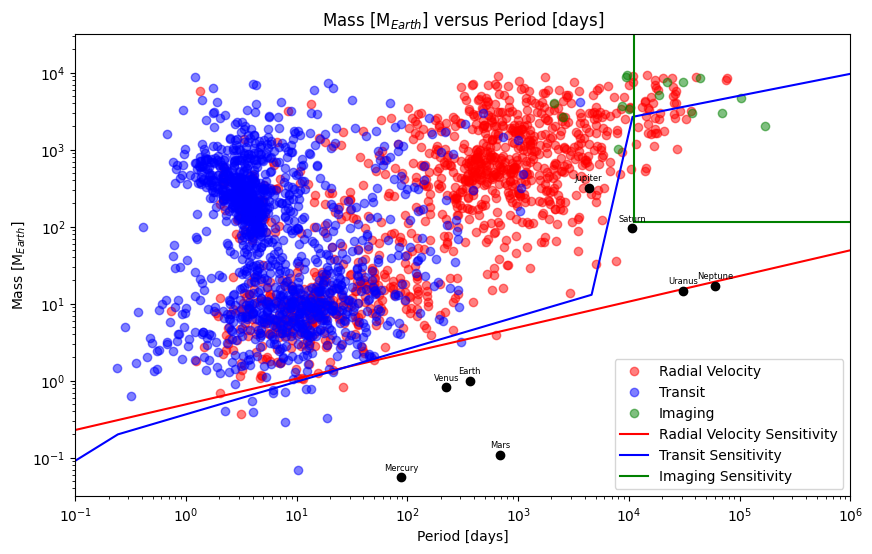

In [29]:
## Plot mass (in terms of Earth mass) versus orbital periods (in days)

# Initialize plot
plt.figure(figsize=(10, 6))

# Group planets by detection methods and plot with assigned colors
for method in selected_methods:
    if method in np.unique(tab["discoverymethod"]):
        ind = np.where(tab["discoverymethod"] == method)
        color = colors.get(method, "black")
        plt.plot(tab["pl_orbper"][ind], tab["pl_bmasse"][ind], "o", color=color, label=method, alpha=0.5)

# Plot sensitivities
plt.plot(period_new.to(u.day), rv_min_mass.decompose().to(u.earthMass), color="red", label="Radial Velocity Sensitivity") # Radial Velocity
plt.plot(period.value, trans_min_mass, color="blue", label="Transit Sensitivity") # Transit
plt.plot([img_min_period, max, max, img_min_period, img_min_period], [img_min_mass, img_min_mass, max, max, img_min_mass], linewidth=1.5, color="green", label="Imaging Sensitivity") # Direct Imaging

# Overplot solar system planets
for index, row in solar_sys.iterrows():
    plt.plot(row["Orbital Period (days)"], row["Mass (M_earth)"], "ko")
    plt.annotate((row["Planet"]), (row["Orbital Period (days)"], row["Mass (M_earth)"]) , textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

# Scale and label axes
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title(r"Mass [M$_{Earth}$] versus Period [days]")
plt.xlabel("Period [days]")
plt.ylabel(r"Mass [M$_{Earth}$]")

# Limiting the x and y axis
plt.xlim(10**(-1), 10**(6)) # Relatively short orbital periods
plt.ylim(10**(-1.5), 10**(4.5)) # Limiting the mass of planets
plt.show()

# II. Mass versus Semi-Major Axis

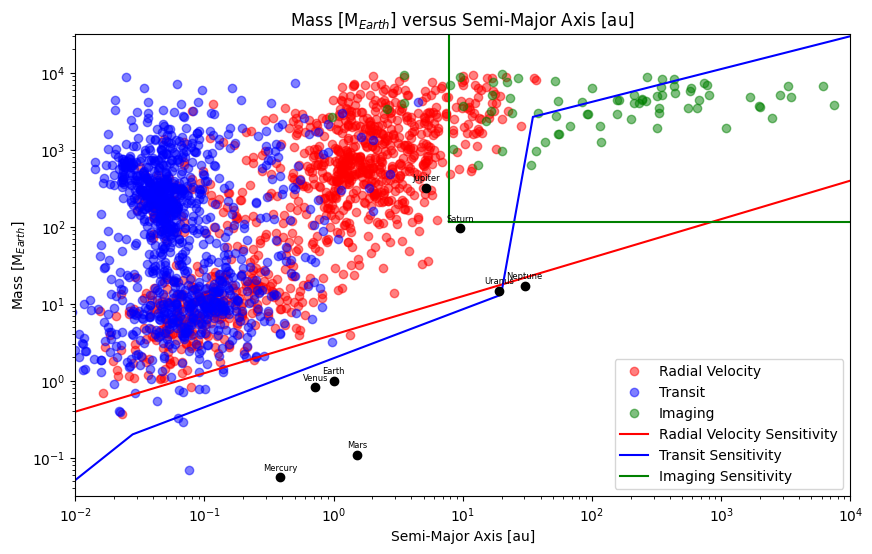

In [30]:
## Plot mass (in terms of Earth mass) versus semi-major axis (in au)

# Initialize plot
plt.figure(figsize=(10, 6))

# Group planets by detection methods and plot with assigned colors
for method in selected_methods:
    if method in np.unique(tab["discoverymethod"]):
        ind = np.where(tab["discoverymethod"] == method)
        color = colors.get(method, "black")
        plt.plot(tab["pl_orbsmax"][ind], tab["pl_bmasse"][ind], "o", color=color, label=method, alpha=0.5)

# Plot sensitivities
plt.plot(a.value, rv_min_mass.decompose().to(u.earthMass), color="red", label="Radial Velocity Sensitivity") # Radial Velocity
plt.plot(a_new.to(u.AU), trans_min_mass, color="blue", label="Transit Sensitivity") # Transit
plt.plot([img_min_sma, max, max, img_min_sma, img_min_sma], [img_min_mass, img_min_mass, max, max, img_min_mass], linewidth=1.5, color="green", label="Imaging Sensitivity") # Direct Imaging

# Overplot solar system planets
for index, row in solar_sys.iterrows():
    plt.plot(row["Semi-major Axis (au)"], row["Mass (M_earth)"], "ko")
    plt.annotate((row["Planet"]), (row["Semi-major Axis (au)"], row["Mass (M_earth)"]) , textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

# Scale and label axes
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title(r"Mass [M$_{Earth}$] versus Semi-Major Axis [au]")
plt.xlabel("Semi-Major Axis [au]")
plt.ylabel(r"Mass [M$_{Earth}$]")

# Limiting the x and y axis
plt.xlim(10**(-2), 10**(4)) # Eliminate large semi-major axes
plt.ylim(10**(-1.5), 10**(4.5)) # Limiting the mass of planets
plt.show()

# III. Radius versus Period

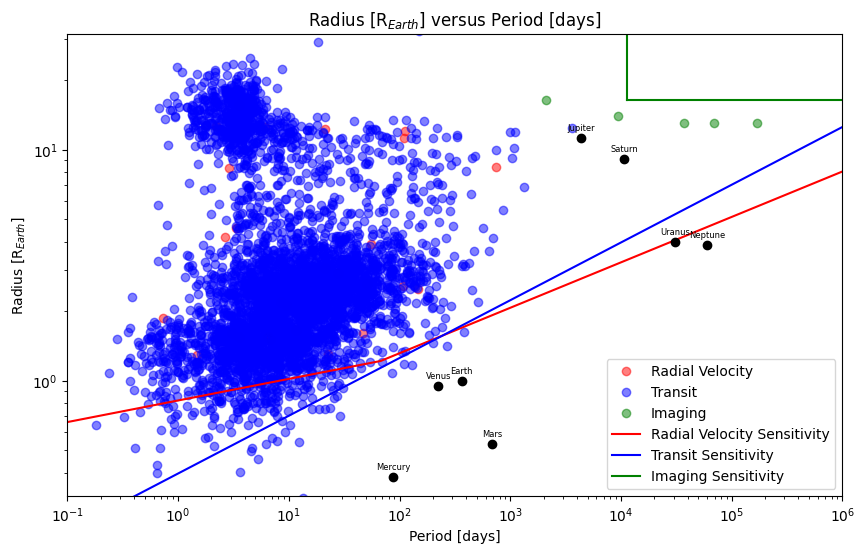

In [31]:
## Plot radius (in terms of Earth radius) versus orbital periods (in days)

# Initialize plot
plt.figure(figsize=(10, 6))

# Group planets by detection methods and plot with assigned colors
for method in selected_methods:
    if method in np.unique(tab["discoverymethod"]):
        ind = np.where(tab["discoverymethod"] == method)
        color = colors.get(method, "black")
        plt.plot(tab["pl_orbper"][ind], tab["pl_rade"][ind], "o", color=color, label=method, alpha=0.5)

# Plot sensitivities
plt.plot(period_new.to(u.day), rv_min_rad, color="red", label="Radial Velocity Sensitivity") # Radial Velocity
plt.plot(period.value, trans_min_rad.decompose().to(u.earthRad), color="blue", label="Transit Sensitivity") # Transit
plt.plot([img_min_period, max, max, img_min_period, img_min_period], [img_min_rad, img_min_rad, max, max, img_min_rad], linewidth=1.5, color="green", label="Imaging Sensitivity") # Direct Imaging

# Overplot solar system planets
for index, row in solar_sys.iterrows():
    plt.plot(row["Orbital Period (days)"], row["Radius (R_earth)"], "ko")
    plt.annotate((row["Planet"]), (row["Orbital Period (days)"], row["Radius (R_earth)"]) , textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

# Scale and label axes
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title(r"Radius [R$_{Earth}$] versus Period [days]")
plt.xlabel("Period [days]")
plt.ylabel(r"Radius [R$_{Earth}$]")

# Limiting the x and y axis
plt.xlim(10**(-1), 10**(6)) # Relatively short orbital periods
plt.ylim(10**(-0.5), 10**(1.5)) # Limiting the radius of planets
plt.show()

# IV. Radius versus Semi-Major Axis

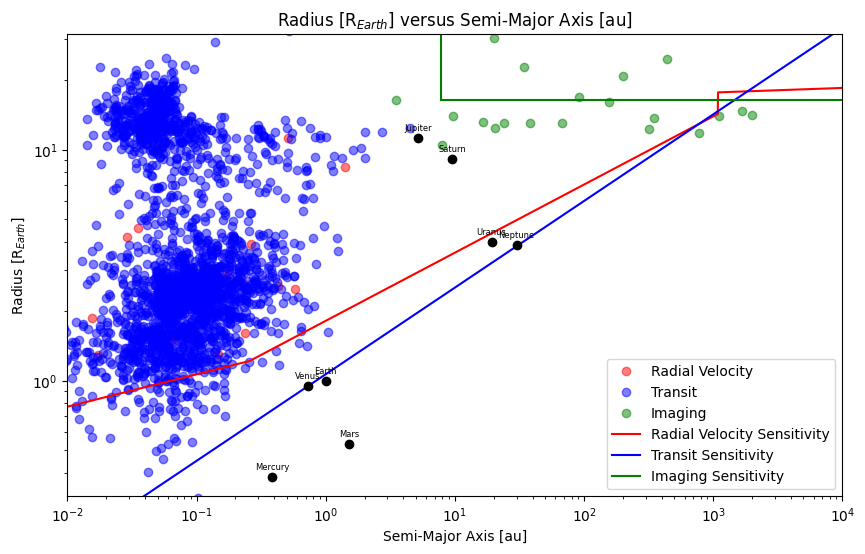

In [32]:
## Plot radius (in terms of Earth radius) versus semi-major axis (in au)

# Initialize plot
plt.figure(figsize=(10, 6))

# Group planets by detection methods and plot with assigned colors
for method in selected_methods:
    if method in np.unique(tab["discoverymethod"]):
        ind = np.where(tab["discoverymethod"] == method)
        color = colors.get(method, "black^")
        plt.plot(tab["pl_orbsmax"][ind], tab["pl_rade"][ind], "o", color=color, label=method, alpha=0.5)

# Plot sensitivities
plt.plot(a.value, rv_min_rad, color="red", label="Radial Velocity Sensitivity") # Radial Velocity
plt.plot(a_new.to(u.AU), trans_min_rad.decompose().to(u.earthRad), color="blue", label="Transit Sensitivity") # Transit
plt.plot([img_min_sma, max, max, img_min_sma, img_min_sma], [img_min_rad, img_min_rad, max, max, img_min_rad], linewidth=1.5, color="green", label="Imaging Sensitivity") # Direct Imaging

# Overplot solar system planets
for index, row in solar_sys.iterrows():
    plt.plot(row["Semi-major Axis (au)"], row["Radius (R_earth)"], "ko")
    plt.annotate((row["Planet"]), (row["Semi-major Axis (au)"], row["Radius (R_earth)"]) , textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

# Scale and label axes
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title(r"Radius [R$_{Earth}$] versus Semi-Major Axis [au]")
plt.xlabel("Semi-Major Axis [au]")
plt.ylabel(r"Radius [R$_{Earth}$]")

# Limiting the x and y axis
plt.xlim(10**(-2), 10**(4)) # Eliminate large semi-major axes
plt.ylim(10**(-0.5), 10**(1.5)) # Limiting the radius of planets
plt.show()

# **Observations of Plots**

#### **(1) Differences between plots**
It appears that our radii range is significantly smaller than our mass range, which makes the data points more compact when plotted. This is likely because our radii are in terms of Earth's radius, which standardizes it significantly, and there is a smaller range of possible physical radii, while the mass can fluctuate more depending on the planet's density. The plots do appear relatively similar, which means that these four observations are closely related.

#### **(2) Overplot solar system planets**
It appears that our solar system's planets, for the most part, would fall outside of the limits we are setting on the plots. Both the periods and semi-major axes appear to be relatively larger than both the average/general periods and semi-major axes of the other exoplanets. That being said, both the radii and masses of our solar system's planets appear to be generally similar to those of the exoplanets.

#### **(3) Plotting detection techniques**
It is clear through these plots that detecting a planet through its transit and radial velcoity are the most common technqiues of detection. That being said, each of the detection techniques appear to have a specific type of planet that it can detect more frequently than other planet types.

* When it comes to mass, a planet with a longer orbital period/semi-major axis is more easily detected through radial velocity measurements.

* A planet with a short period/semi-major axis but a high mass would be more easily detected through its transit. That being said, when radius is being measured, it appears that measuring through a planet's transit is nearly the sole technique used.

* Direct imaging is used when either (1) the mass is large, or (2) the period/semi-major axis is incredibly large (over 10$^{3}$ days (period) or 10au (semi-major axis)).  

#### **(4) Plotting detection sensitivities**
Transitioning each sensitivity from semi-major axis to period was fairly straight forward, as there is a constant relationship between the two. The difficulty came when converting between mass and radius, and vice versa, as densities do not remain constant. We had to create a function that took the power log mass-radius relation into account to ensure that as mass and radius increased, the relation between the two converted as needed.

In [17]:
## Radial Velocity
# Only use planets that were discovered via "Radial Velocity"
rv_planets = tab[tab['discoverymethod'] == 'Radial Velocity']
rv_planets = rv_planets[['pl_bmasse','pl_orbsmax']] # Obtain their mass and semi-major axis

# Count number of planets with a mass higher than calculated rv_min_mass
count = 0
for mass, a in rv_planets:
  threshold = K * m_solar * np.sqrt(a*u.au/(ac.G*m_solar))
  if mass*u.earthMass > threshold.decompose().to(u.earthMass):
    count += 1

# Print sensitivity accuracy
percent = count / len(rv_planets) * 100
print(percent)

99.27007299270073


In [18]:
## Transit
# Only use planets that were discovered via "Transit"
transit_planets = tab[tab['discoverymethod'] == 'Transit']
transit_planets = transit_planets[['pl_rade','pl_orbper']] # Obtain their radius and period

# Count number of planets with a radius higher than calculated tran_min_rad
count = 0
for radius, period in transit_planets:
  threshold = np.sqrt(3*np.sqrt(period*u.day/time)) * u.earthRad
  if radius*u.earthRad > threshold.decompose().to(u.earthRad):
    count += 1

# Print sensitivity accuracy
percent = count / len(transit_planets) * 100
print(percent)

98.91530117701362


In [19]:
## Direct Imaging
# Only use planets that were discovered via "Imaging"
img_planets = tab[tab['discoverymethod'] == 'Imaging']
img_planets = img_planets[['pl_bmasse','pl_orbsmax']] # Obtain their mass and semi-major axis

# Count number of planets with a mass higher than calculated img_min_mass
count = 0
for mass, a in img_planets:
  if mass > 114 and a > 8:
    count += 1

# Print sensitivity accuracy
percent = count / len(img_planets) * 100
print(percent)

86.58536585365853


We can conclude that our precision limit estimates are fairly accurate, with over 99% of planets that were actually discovered via Radial Velocity were accurately predicted by our sensitivity limit, with 98% accuracy for Transit and 86% accuracy for Direct Imaging.

#### **(5) Detection of a Jupiter-like planet around a Sun-like star**
Using our detection methods, we will now predict whether these three detection methods would be able to detect a Jupiter-like planet around a Sun-like star.

Our first attempt would be using the Radial Velocity method. To simplify, we will assume our system is at a 90-degree angle to our view (making $sin(i) = 1$). We rearranged our formula from above to solve for K, and then plugged in our values.

In [20]:
# Set constants
mass = u.jupiterMass
a = 5.204*u.au

# Determine K value
K = mass / (m_solar * np.sqrt(a/(ac.G*m_solar)))
print(K.decompose())

17.626182872876075 m / s


Our resulting amplitude is 17.6 m/s, which is greater than our state-of-the-art instruments detection limit of 0.5 m/s, meaning that this method would be able to detect our planet.

The next attempt at detection used Transit Photometry, which required a rearrangement of the formula above: $\text{time} = \frac{9 \times \text{earthRad}^4 \times \text{period}}{r_p^4}$.


In [21]:
# Set constants
radius = u.jupiterRad
period = 4332.59*u.day

# Determine time value
time = (9 * u.earthRad**4 * period) / (radius**4)
print(time.decompose().to(u.day))

2.4701629992653675 d


Our resulting time necessity would be 2.47 days, which is less than our state-of-the-art detection time limit of 1 year, as discussed above. This means that the Transit Photometry method would be able to detect our planet.

The final detection method utilized to detect a Jupiter-like planet around a Sun-like star was Direct Imaging. We determined the minimum radius required is 16.4 earthRad, and the minimum semi-major axis is 8 au.

In [22]:
# Convert to proper units
print(u.jupiterRad.to(u.earthRad))
print(5.204*u.au)

11.20898073093868
5.204 AU


As we can see, both our planet's radius (11.2 earthRad) and semi-major axis (5.2 au) are too small to be detected via Direct Imaging. The planet is too close to its parent star to be detected as a seperate object, and it is far too small to show up on the image itself.

# **Conclusion**
The purpose of this research was to determine the sensitivity limits of three different detection methods of discovering exoplanets. Each of the three methods (radial velocity, transit photometry, and direct imaging) required assumptions regarding the state-of-the-art technology being utilized and assumptions regarding the planet itself. We can conclude that both Radial Velocity and Transit Photometry would be able to detect a Jupiter-like planet around a Sun-like star, while Direct Imaging would not be able to, as this theoretical planet is both too small and too close to its parent star.